## <span style='font-family:Georgia'> ElasticNet
The purpose of this workbook is cascade estimation of the target variable using the `ElasticNet` model with `RollingOriginForwardValidation`.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
from typing import List
from sklearn import preprocessing
from scipy.stats import iqr

from typing import Dict
from typing import List

import dateutil
import functools

from sklearn.linear_model import ElasticNetCV

import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

sys.path.append("../")
from cross_validation import RollingOriginForwardValidation
from time_series_retransformer import Time_Series_Retransformer

In [2]:
def convert_to_datetime(df: pd.DataFrame, colnames: List[str]) -> pd.DataFrame:
    for col in colnames:
        df[col] = pd.to_datetime(df[col])
    return df

In [3]:
def plot_test_pred(y_pred, y_actual, y_train=None, title="Retransformed series"):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=80)

    ax.plot(y_actual, label="Actual (test)", marker="o", color="tab:green")
    ax.plot(y_pred, label="Forecast", marker="o", ls="--", color="tab:red")
    if y_train is not None: ax.plot(y_train, label="Actual", color="tab:blue")
    ax.set_xlabel("Time", fontsize=20)
    ax.tick_params(axis="x", rotation=0, labelsize=12)
    ax.grid(alpha=0.4)
    ax.set_title(title, fontsize=22)

    plt.legend(loc="upper left")
    fig.tight_layout()
    plt.show()

In [4]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)  # ME
    mae = np.mean(np.abs(forecast - actual))  # MAE
    mpe = np.mean((forecast - actual) / actual)  # MPE
    rmse = np.mean((forecast - actual) ** 2) ** 0.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]  # corr
    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins / maxs)  # minmax
    return {
        "mape": mape,
        "me": me,
        "mae": mae,
        "mpe": mpe,
        "rmse": rmse,
        "corr": corr,
        "minmax": minmax,
    }

In [5]:
mod_path = "../../datasets/time_series/PCEC96_perc_diff_lag_1.csv"
ds_path = "../../datasets/time_series/PCEC96.csv"

y_code = "PCEC96"

In [6]:
df_mod = pd.read_csv(mod_path)
df_mod = convert_to_datetime(df_mod, ["reference_date"])
data_source = pd.read_csv(ds_path, decimal=",")
data_source = convert_to_datetime(data_source, ["reference_date"])

In [7]:
y_fields = df_mod.filter(regex=f"{y_code}*").columns
display(y_fields)

assert len(y_fields) > 0

Index(['PCEC96_perc_diff_lag_1'], dtype='object')

## Parameters section

In [8]:
y_field = y_fields[0]
reference_date = pd.to_datetime("2023-02-01")
n_periods = 12

lambda1 = [0.001, 0.01, 0.1, 1, 10]

## Execution section

In [9]:
# all data pre-processing
y_df = df_mod[["reference_date", y_field]].set_index('reference_date').sort_index()

assert y_df.first_valid_index() < reference_date and y_df.last_valid_index() >= reference_date

date_range = [
    y_df.first_valid_index(),
    reference_date
]

print(f'{y_field} date range: [{date_range[0].date().strftime("%Y-%m-%d")}, {date_range[1].date().strftime("%Y-%m-%d")}].\n')

y_series = y_df[y_field].loc[date_range[0]:date_range[1]]
X_df = df_mod.drop(columns=y_fields).set_index('reference_date').sort_index().loc[date_range[0]:date_range[1]]
fcst_ref_dates = y_series.tail(n_periods).index
print(f'Reference dates: {fcst_ref_dates}.\n')

# assert there are no missing values in y series
assert y_series.isna().any() == False

# drop predictors with missings
c = X_df.isna().any() == False
X_model = X_df[c.index[c]]
excl = set(X_df.columns) - set(X_model.columns)
if len(excl) > 0: print(f"Variables excluded due to missing values: {excl}.\n")

df = pd.merge(X_model, y_series, left_index=True, right_index=True).sort_index()
assert df.index.min() == date_range[0] and df.index.max() == date_range[1]

display(Markdown(f"### Modeling dataframe:"))
display(df)

PCEC96_perc_diff_lag_1 date range: [2003-03-01, 2023-02-01].

Reference dates: DatetimeIndex(['2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01'],
              dtype='datetime64[ns]', name='reference_date', freq=None).



### Modeling dataframe:

,LLBFRIM027NBOG_diff_lag_1,LLBFRIM027NBOG_perc_diff_lag_1,LLBFRIM027SBOG_diff_lag_1,LLBFRIM027SBOG_perc_diff_lag_1,LNS12026619_diff_lag_1,LNS12026619_perc_diff_lag_1,LNS12600000_diff_lag_1,LNS12600000_perc_diff_lag_1,LNS13023558_diff_lag_1,LNS13023570_diff_lag_1,...,USWTRADE_perc_diff_lag_3,WPSFD49207_diff_lag_1,WPSFD49502_diff_lag_1,WPSID61_diff_lag_1,WPSID61_diff_lag_3,WPSID62_diff_lag_1,WPSID62_diff_lag_3,WTISPLC_diff_lag_1,WTISPLC_diff_lag_3,PCEC96_perc_diff_lag_1
reference_date,,,,,,,,,,,,,,,,,,,,,
2003-03-01,-1.853394,-0.682922,-2.045593,-0.755972,-207.0,-2.762947,225.0,0.936018,-0.200001,0.500000,...,-0.146812,1.300003,1.599991,2.500000,6.300003,17.899994,33.299995,-2.320000,4.129999,0.574669
2003-04-01,-2.545197,-0.944280,-2.855896,-1.063469,-6.0,-0.082361,168.0,0.692412,0.900000,-0.100000,...,-0.041257,-1.800003,-2.300003,-3.199997,1.700012,-24.000000,0.199997,-5.299999,-4.689999,0.473108
2003-05-01,-0.059418,-0.022254,1.546997,0.582258,110.0,1.511197,66.0,0.270149,-1.100000,-0.200000,...,-0.290198,-0.300003,-0.399994,-0.700012,-1.400009,1.699997,-4.400009,-0.110001,-7.730000,0.321433
2003-06-01,-0.305786,-0.114555,-0.821198,-0.307292,-11.0,-0.148870,280.0,1.142997,1.600000,0.200000,...,-0.398037,0.800003,1.100006,0.700012,-3.199997,5.600006,-16.699997,2.580000,-2.830000,0.535802
2003-07-01,-5.819794,-2.182741,-6.306122,-2.367027,-72.0,-0.975874,-528.0,-2.131009,-1.100000,0.300000,...,-0.455849,0.100006,0.099991,0.199997,0.199997,-3.600006,3.699997,0.040001,2.510000,0.450871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,18.932129,1.959415,23.471130,2.413344,-236.0,-3.043198,164.0,0.624786,-0.400000,0.300000,...,0.623511,2.098007,2.665009,-0.653992,-4.382996,-32.126007,-26.947998,3.290001,-14.070000,0.332505
2022-11-01,32.999756,3.349734,19.555481,1.963348,157.0,2.088044,-298.0,-1.128232,-1.400000,1.099999,...,0.395300,1.231995,1.429993,-1.295013,-2.276001,-9.239990,-51.941986,-3.180000,-9.299995,-0.319491
2022-12-01,30.364502,2.982335,15.081055,1.484965,370.0,4.820219,679.0,2.600038,0.699999,-0.700000,...,0.416403,-2.927002,-4.559998,-6.621979,-8.570984,4.556000,-36.809998,-7.930000,-7.820000,-0.331051


In [10]:
# models training
forecasts_df = pd.DataFrame()

for ref_date in tqdm(fcst_ref_dates):
    
    # split between train and test subsets
    df_train, df_test = df.loc[df.index < ref_date], df.loc[df.index >= ref_date]
    X_train, y_train = df_train[X_model.columns], df_train[[y_field]]
    X_test, y_test = df_test[X_model.columns], df_test[[y_field]]
    
    # feature scaling
    scaler = preprocessing.RobustScaler()
    X_train_stat_ss = scaler.fit_transform(X_train.values)
    X_train_df_ss = pd.DataFrame(
        X_train_stat_ss, columns=X_train.columns, index=X_train.index
    )

    scaler = preprocessing.RobustScaler()
    X_test_stat_ss = scaler.fit_transform(X_test.values)
    X_test_df_ss = pd.DataFrame(
        X_test_stat_ss, columns=X_test.columns, index=X_test.index
    )

    # model estimation
    rtscv = RollingOriginForwardValidation()

    rts_model = ElasticNetCV(
        random_state=0,
        n_jobs=-1,
        l1_ratio=np.arange(0.9, 0.99, 0.01),  # strong regularization due to number of features
        alphas=[1e-2, 2e-2, 3e-2, 4e-2, 5e-2],
        cv=rtscv,
        fit_intercept=True,
        max_iter=5000,  # max iter no. increased due to convergence warning
        tol=2.276e-03  # tolerance increased due to convergence warning
    )
    rts_model.fit(X_train_df_ss, y_train.values.ravel())

    # forecasting
    fc = rts_model.predict(X_test_df_ss)
    fc_series = pd.Series(fc, index=X_test_df_ss.index)
    
    # merging results
    forecasts_df = pd.concat([forecasts_df, fc_series], axis=1)

cols = ["model" + str(i + 1) for i in range(forecasts_df.shape[1])]
forecasts_df.columns = cols

forecasts_df

  0%|          | 0/12 [00:00<?, ?it/s]

,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12
2022-03-01 00:00:00,0.396605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-01 00:00:00,0.351807,0.364658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-01 00:00:00,-0.111183,-0.062759,-0.038250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-01 00:00:00,0.067204,0.081545,0.104311,0.042835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-01 00:00:00,0.096391,0.089325,0.087941,0.067863,0.115525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-01 00:00:00,0.443596,0.462676,0.512167,0.435399,0.398973,0.374633,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-01 00:00:00,0.169520,0.199270,0.233357,0.196395,0.209111,0.220757,0.273543,NaN,NaN,NaN,NaN,NaN
2022-10-01 00:00:00,0.375948,0.369414,0.402736,0.369086,0.370711,0.344203,0.454423,0.371938,NaN,NaN,NaN,NaN
2022-11-01 00:00:00,-0.178891,-0.147803,-0.151575,-0.159061,-0.117277,-0.140494,-0.138095,-0.068453,0.000873,NaN,NaN,NaN
2022-12-01 00:00:00,0.020888,0.039724,0.052843,0.049751,0.074635,0.038103,0.049247,0.080025,0.146226,0.065404,NaN,NaN


## Forecasts preview

In [11]:
y_pred = pd.Series(np.diag(forecasts_df), index=[forecasts_df.index, forecasts_df.columns])
display(y_pred)

y_pred = y_pred.reset_index(level=1, drop=True).sort_index()

2022-03-01 00:00:00  model1     0.396605
2022-04-01 00:00:00  model2     0.364658
2022-05-01 00:00:00  model3    -0.038250
2022-06-01 00:00:00  model4     0.042835
2022-07-01 00:00:00  model5     0.115525
2022-08-01 00:00:00  model6     0.374633
2022-09-01 00:00:00  model7     0.273543
2022-10-01 00:00:00  model8     0.371938
2022-11-01 00:00:00  model9     0.000873
2022-12-01 00:00:00  model10    0.065404
2023-01-01 00:00:00  model11    0.631571
2023-02-01 00:00:00  model12    0.196896
dtype: float64

In [12]:
summary = y_pred.to_frame().rename(columns={0: "forecast"})
summary[y_field] = y_series.loc[forecasts_df.index]
summary.index.name = "date"

summary

,forecast,PCEC96_perc_diff_lag_1
date,,
2022-03-01,0.396605,0.291723
2022-04-01,0.364658,0.158591
2022-05-01,-0.038250,0.068162
2022-06-01,0.042835,0.203647
2022-07-01,0.115525,-0.004246
2022-08-01,0.374633,0.479422
2022-09-01,0.273543,0.258647
2022-10-01,0.371938,0.332505
2022-11-01,0.000873,-0.319491


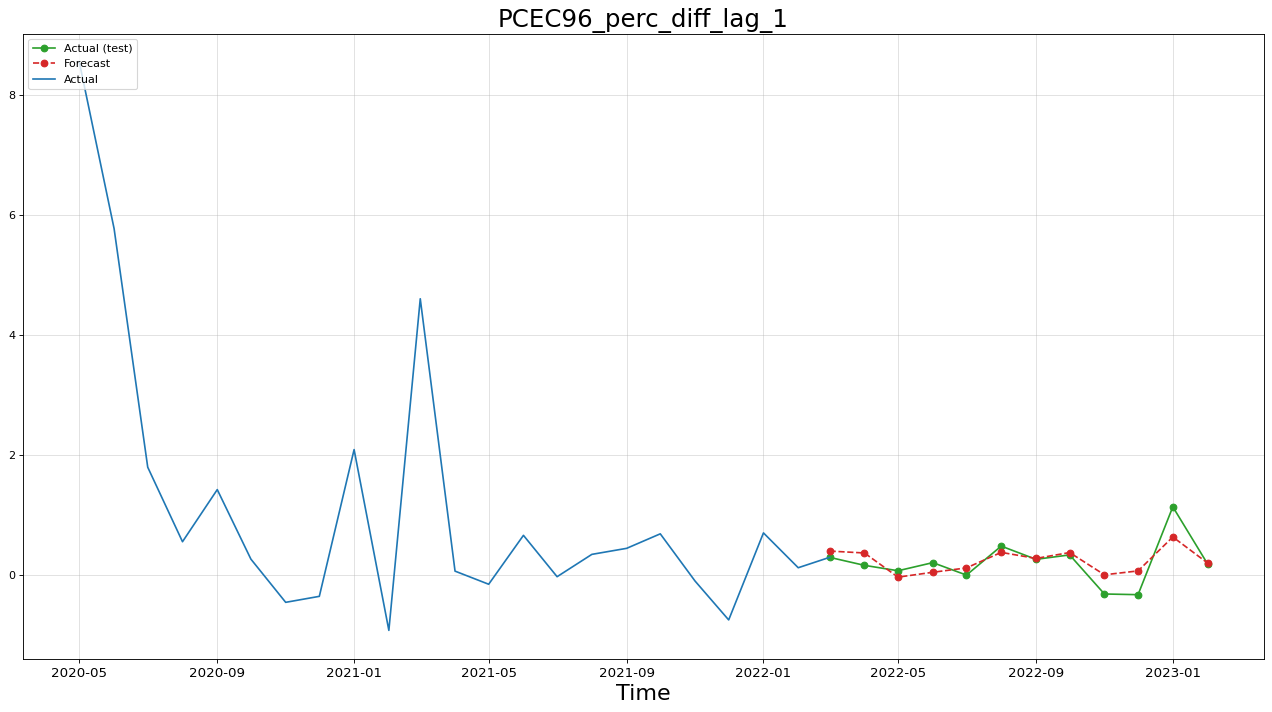

In [13]:
x_start_date = "2020-05-01"

plot_test_pred(
    y_pred=summary["forecast"],
    y_actual=summary[y_field],
    y_train=y_series.loc[x_start_date:summary.index.min()],
    title=y_field,
)

In [14]:
# forecast retransformation
y_series_orig = (
    data_source
        .set_index("reference_date")
        .sort_index()[y_code]
).loc[y_series.index]
y_series_orig.index.name = "date"

tsr = Time_Series_Retransformer(df_orig=y_series_orig, df_diff=summary["forecast"])
retransf_fcst = tsr.make_inv_perc_diff(order=1)

summary['retransformed_forecast'] = retransf_fcst
summary[y_code] = y_series_orig.loc[retransf_fcst.index]

summary

,forecast,PCEC96_perc_diff_lag_1,retransformed_forecast,PCEC96
date,,,,
2022-03-01,0.396605,0.291723,14075.905155,14061.2
2022-04-01,0.364658,0.158591,14127.234043,14083.5
2022-05-01,-0.038250,0.068162,14121.830329,14093.1
2022-06-01,0.042835,0.203647,14127.879459,14121.8
2022-07-01,0.115525,-0.004246,14144.200631,14121.2
2022-08-01,0.374633,0.479422,14197.189505,14188.9
2022-09-01,0.273543,0.258647,14236.024889,14225.6
2022-10-01,0.371938,0.332505,14288.974085,14263.3
2022-11-01,0.000873,-0.319491,14289.098865,14204.3


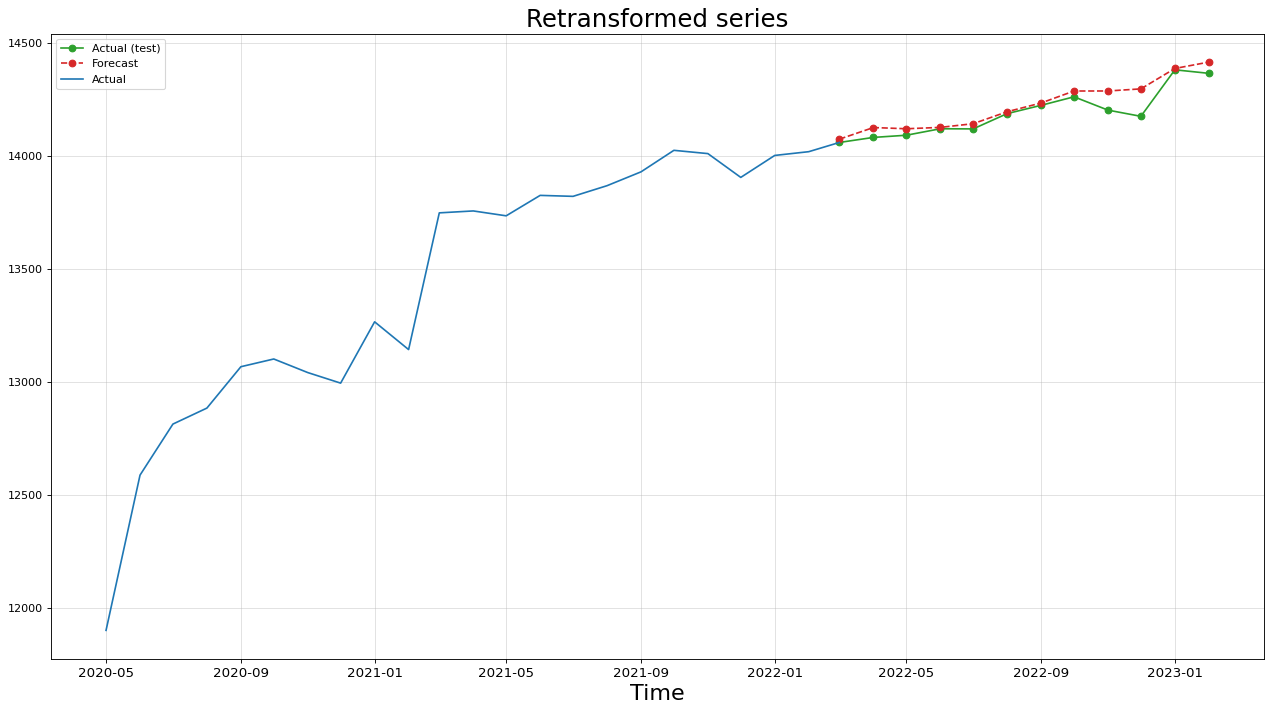

In [15]:
plot_test_pred(
    y_pred=summary["retransformed_forecast"],
    y_actual=summary[y_code],
    y_train=y_series_orig.loc[x_start_date:summary.index.min()],
    title="Retransformed series",
)

## Coefficients

In [16]:
coefficients_df = pd.DataFrame(
    rts_model.coef_,
    index=X_train.columns,
    columns=['coefficient']).append(pd.Series({'coefficient': rts_model.intercept_}, name='Intercept')
    )
coefficients_df["abs_coef"] = abs(coefficients_df.coefficient)

coefficients_df.sort_values(by=["abs_coef"], ascending=False)[:50]

,coefficient,abs_coef
Intercept,0.196896,0.196896
RRSFS_diff_lag_1,0.147870,0.147870
RSFSDP_perc_diff_lag_1,0.084731,0.084731
CFNAI,0.061190,0.061190
ALTSALES_diff_lag_1,0.048701,0.048701
CANDH_diff_lag_1,0.041498,0.041498
CANDH_diff_lag_3,0.040080,0.040080
BUSLOANS_diff_lag_1,-0.038533,0.038533
IPNCONGD_diff_lag_1,0.033332,0.033332
CES0600000007_perc_diff_lag_1,-0.028763,0.028763


## Evaluation

In [17]:
forecast_accuracy(actual=summary[y_field], forecast=summary["forecast"])

{'mape': 2.944831224238144,
 'me': 0.028470453641110182,
 'mae': 0.17432355851600823,
 'mpe': -2.6253438019713466,
 'rmse': 0.2292917664381087,
 'corr': 0.8396852215647377,
 'minmax': 31.503073543550645}

In [18]:
forecast_accuracy(actual=summary[y_code], forecast=summary["retransformed_forecast"])

{'mape': 0.0024823308230810556,
 'me': 35.225917726284024,
 'mae': 35.225917726284024,
 'mpe': 0.0024823308230810556,
 'rmse': 49.026387269340965,
 'corr': 0.94754556834436,
 'minmax': 0.002470473849199295}